# Agenda  <a name="backtotop"></a>
---

1. [General Trend](#GT)
2. [Fit By Logistic Regression](#LR)
3. [Fit By Multinomial Naive Bayes](#MNB)
4. [Fit By Random Forest](#RF)
5. [Fit By Gradient Boosting Machines ](#GBM)
6. [Fit By Naive Bayes SVM](#NBSVM)
7. [Fit By Multilayer Perceptron Neural Network(MLP)](#MLP)
8. [Fit By LSTM Neural Network](#LSTM)
9. [Fit By Bidirectional LSTM Neural Network](#BD_LSTM)
10. [Fit By Convolutional Neural Network](#CNN)

# Introduction

The project aims to predict daily rising/dropping trending of Dow Jones Industrial Average(AJIA) by news headlines. In other words, this is a binary classification NLP project<br>

**News data** is crawled from Reddit WorldNews Channel <br>
**DJIA data** is downloaded from Yahoo Finance <br>

The models below may not be well optimized but fair enough to set a reasonable baseline <br>

reference: https://www.kaggle.com/aaron7sun/stocknews

## Accuracy Overview

- **61%** -- Logistic Regression
- **55%** -- Multinomial Naive Bayes
- **52%** -- Random Forest
- **54%** -- Gradient Boosting Machines
- **52%** -- Naive Bayes SVM
- **56%** -- Multilayer Perceptron Neural Network(MLP)
- **55%** -- LSTM Neural Network
- **55%** -- Bidirectional LSTM Neural Network
- **54%** -- Convolutional Neural Network

## Libraries

In [2]:
%matplotlib inline
import re
import six
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import check_X_y, check_array
from sklearn.preprocessing import LabelBinarizer, normalize
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.svm import LinearSVC 
from sklearn.base import BaseEstimator, ClassifierMixin

from scipy.sparse import issparse
from scipy import sparse

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tqdm import tqdm
from abc import ABCMeta



Using TensorFlow backend.


## Raw Data

In [3]:
path = "data/"
DJIA_fn = "DJIA_table.csv"
News_fn = "Combined_News_DJIA.csv"

DJIA_df = pd.read_csv(path + DJIA_fn)
DJIA_df = DJIA_df.sort_values("Date")
DJIA_df.index = range(len(DJIA_df))

News_df = pd.read_csv(path + News_fn)
News_df = News_df.sort_values("Date")
News_df.index = range(len(News_df))

## General Trend <a name = "GT"></a>

[Back to Top](#backtotop)

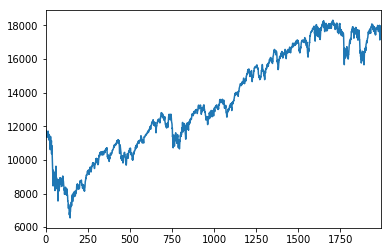

In [4]:
DJIA_df["Adj Close"].plot()
plt.show()

## Clean data in News_df

In [5]:
def RemoveQuote(tmp_str):
    s_quote = False
    d_quote = False
    start_list = []
    end_list = []
    mid_str = tmp_str[5:len(tmp_str)-5]
    for i in range(5):
        if (not s_quote) or (not d_quote):
            try:
                if tmp_str[i] != "\'" and tmp_str[i] != "\"":
                    if i <=2 and tmp_str[i] == 'b':
                        continue
                    start_list.append(tmp_str[i])
                if tmp_str[-5+i] != "'" and tmp_str[-5+i] != '"':
                    end_list.append(tmp_str[-5+i])
            except:
                print(tmp_str)

    tmp_str = "".join(start_list) + mid_str + "".join(end_list)
    return tmp_str

headline_columns = [x for x in News_df.columns if re.match("Top", x)]
for col in headline_columns:
    News_df[col] = News_df[col].apply(lambda x: RemoveQuote(x) if x == x else x)
Comb_df = DJIA_df.merge(News_df, on = "Date", how = "inner")

## Make Training Data and Testing Data (8:2)

In [6]:
train_index = pd.to_datetime(DJIA_df.Date, format = "%Y-%m-%d") < pd.to_datetime("2014-12-31", format = "%Y-%m-%d")
train_data = Comb_df[train_index]
test_data = Comb_df[~train_index]

## Joint Top Hottest Headlines and Tokenize and Vecterize Text into Metrix

In [7]:
joint_headlines_train = train_data[headline_columns[0]]
joint_headlines_test = test_data[headline_columns[0]]
for i in range(1, len(headline_columns)):
    joint_headlines_train += (' ' + train_data[headline_columns[i]].apply(lambda x: str(x) if x == x else ""))
    joint_headlines_test += (' ' + test_data[headline_columns[i]].apply(lambda x: str(x) if x == x else ""))

basicVetorizer = TfidfVectorizer(min_df=0.03, max_df=0.97, max_features = 200000, ngram_range = (2, 2))
basic_train = basicVetorizer.fit_transform([x for x in joint_headlines_train.values if x == x])
basic_test = basicVetorizer.transform([x for x in joint_headlines_test.values if x == x])
basic_whole = basicVetorizer.fit_transform([x for x in joint_headlines_train.append(joint_headlines_test).values if x==x])

# Fit by Logistic Regression <a name = "LR"></a>
    
[Back to Top](#backtotop)
> Find the best score by Grid Search on Penalty C <br>
> **Assumptions:** <br>
> - The outcome is binary <br>
> - The observations are independent to each other <br>
> - Absence of multicollinearity <br>
> - Linearity of independent variables and log odds <br>
> - Large size of database <br>


In [7]:

logistic_model = LogisticRegression(solver='lbfgs')
# logistic_model = logistic_model.fit(basic_train, train_data.Label)


gs = GridSearchCV(logistic_model, {'C': [0.001,0.01,0.1,1,10,100,1000]}, cv = 12, scoring='accuracy',)
gs.fit(TruncatedSVD(n_components=10).fit_transform(basicVetorizer.fit_transform([x for x in joint_headlines_train.append(joint_headlines_test).values if x == x])), Comb_df.Label.values)

print("Best Score = ", gs.best_score_)

Best Score =  0.5354449472096531


**Comment**:
> Logistic perform the best when C is around 0.001
> The length of tokens does not really change the accuracy (tried 1-3 grams)

## Reduce Tfidf Dimension by TruncatedSVD (PCA does not adapt to sparse matrix)

In [8]:
from sklearn.decomposition import TruncatedSVD
accuracy_list = []

for num_compo in range(1, 632):
    SVD_model = TruncatedSVD(n_components=num_compo)
    basic_train_svd = SVD_model.fit_transform(basic_train)
    basic_test_svd = SVD_model.transform(basic_test)
    logistic_model = logistic_model.fit(basic_train_svd, train_data.Label)
    accuracy_list.append(accuracy_score(logistic_model.predict(basic_test_svd), test_data.Label))

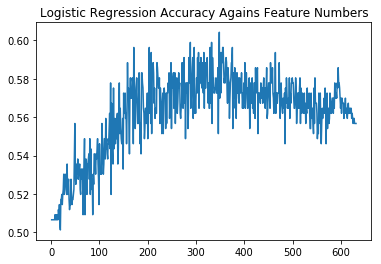

In [9]:
plt.plot(range(1, 632), accuracy_list)
plt.title("Logistic Regression Accuracy Agains Feature Numbers")
plt.show()

**Comment:**
> The graph shows the extraordinary features pottentially reduce the accruacy from 0.02-0.01 <br>
> The most ideal accruacy was made at around 480 number of features <br>

# Fit by Multinomial Naive Bayes <a name = "MNB"></a>

[Back to Top](#backtotop)

In [10]:
NB_model = MultinomialNB()
param = {"alpha": np.arange(0, 10, 0.2)}
gd_NB = GridSearchCV(NB_model, param, cv = 5)
gd_NB.fit(basic_whole, Comb_df.Label.values)
print("Best Score = %.2f with alpha = %.2f"%(gd_NB.best_score_, gd_NB.best_params_['alpha'] ))

/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best Score = 0.55 with alpha = 7.40


## Reduce Tfidf Dimension by TruncatedSVD (PCA does not adapt to sparse matrix)
**Notice**: <br>
By practice, this won't work since SVD created negative input for naive base, **which is not allowed**
<br>
```python 
SVD_model = TruncatedSVD(n_components=380)
basic_train_svd = SVD_model.fit_transform(basic_train)
basic_test_svd = SVD_model.transform(basic_test)

NB_model = MultinomialNB()
NB_model = NB_model.fit(basic_train_svd, train_data.Label.values)
accuracy_score(NB_model.predict(basic_test_svd), test_data.Label.values)
```

# Fit by Random Forest <a name = "RF"></a>

[Back to Top](#backtotop)

**Comment:**<br>
- Even it is not shown below, I tuned the model by **N_estimators, max_depth, min_samples_split, min_samples_leaf, max_features** respectively but the accuracy did not indicate any strong changes

In [11]:
accuracy_list = []
cv = 10
cv_list = []
for i in range(cv):
    RF_model = RandomForestClassifier(n_estimators= 32)
    RF_model = RF_model.fit(basic_train, train_data.Label.values)
    cv_list.append(accuracy_score(RF_model.predict(basic_test), test_data.Label.values))
new_accuracy = np.average(cv_list)
print("Average accuarcy = ", new_accuracy)

Average accuarcy =  0.520580474934037


### TruncatedSVD + Random Forest
**Comment:**
- The dimension reduction does not really improve the prediction

In [ ]:
accuracy_list = []
RF_model = RandomForestClassifier(n_estimators= 32)
rang = range(1, 632)
for num_compo in tqdm(rang):
    SVD_model = TruncatedSVD(n_components=num_compo)
    basic_train_svd = SVD_model.fit_transform(basic_train)
    basic_test_svd = SVD_model.transform(basic_test)
    RF_model = RF_model.fit(basic_train_svd, train_data.Label)
    accuracy_list.append(accuracy_score(RF_model.predict(basic_test_svd), test_data.Label))

In [ ]:
plt.plot(rang, accuracy_list)
plt.show()

# Fit by Gradient Boosting Machines <a name = "GBM"></a>

[Back to Top](#backtotop)

**Comment**:<br>
The result is pretty much very similar to Random Forest

In [8]:
accuracy_list = []
cv = 10
cv_list = []
for i in range(cv):
    GBM_model = GradientBoostingClassifier(n_estimators= 10, n_iter_no_change = 3)
    GBM_model = GBM_model.fit(basic_train, train_data.Label.values)
    cv_list.append(accuracy_score(GBM_model.predict(basic_test), test_data.Label.values))
new_accuracy = np.average(cv_list)
print("Average accuarcy = ", new_accuracy)

Average accuarcy =  0.5058047493403693


In [9]:
accuracy_list = []
GBM_model = GradientBoostingClassifier(n_estimators= 32)
rang = range(1, 632)
for num_compo in tqdm(rang):
    SVD_model = TruncatedSVD(n_components=num_compo)
    basic_train_svd = SVD_model.fit_transform(basic_train)
    basic_test_svd = SVD_model.transform(basic_test)
    GBM_model = GBM_model.fit(basic_train_svd, train_data.Label)
    accuracy_list.append(accuracy_score(GBM_model.predict(basic_test_svd), test_data.Label))

100%|██████████| 631/631 [12:33<00:00,  2.49s/it]


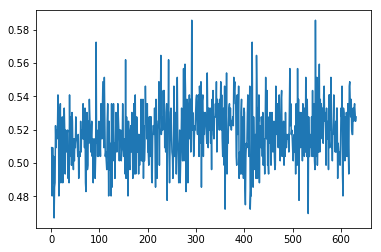

In [10]:
plt.plot(rang, accuracy_list)
plt.show()

# Fit by Naive Bayes SVM <a name = "NBSVM"></a>

[Back to Top](#backtotop)

**Comment**:<br>
- Naive Base(NB) and Support Vector Machine(SVM) are widely used as base-line in test-related task. Their accuracy varies significantly across varients, features and datasets
- **NB does better job than SVM in short snippet sentiment tasks, while SVM outperforms NB in long documents**
- A SVM varients using NB log-count ratio as a feature constantly performs well

In [11]:

class NBSVM(six.with_metaclass(ABCMeta, BaseEstimator, ClassifierMixin)):

    def __init__(self, alpha=1.0, C=1.0, max_iter=10000):
        self.alpha = alpha
        self.max_iter = max_iter
        self.C = C
        self.svm_ = [] # fuggly

    def fit(self, X, y):
        X, y = check_X_y(X, y, 'csr')
        _, n_features = X.shape

        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes_ = labelbin.classes_
        if Y.shape[1] == 1:
            Y = np.concatenate((1 - Y, Y), axis=1)

        # LabelBinarizer().fit_transform() returns arrays with dtype=np.int64.
        # so we don't have to cast X to floating point
        Y = Y.astype(np.float64)

        # Count raw events from data
        n_effective_classes = Y.shape[1]
        self.class_count_ = np.zeros(n_effective_classes, dtype=np.float64)
        self.ratios_ = np.full((n_effective_classes, n_features), self.alpha,
                                 dtype=np.float64)
        self._compute_ratios(X, Y)

        # flugglyness
        for i in range(n_effective_classes):
            X_i = X.multiply(self.ratios_[i])
            svm = LinearSVC(C=self.C, max_iter=self.max_iter)
            Y_i = Y[:,i]
            svm.fit(X_i, Y_i)
            self.svm_.append(svm) 

        return self

    def predict(self, X):
        n_effective_classes = self.class_count_.shape[0]
        n_examples = X.shape[0]

        D = np.zeros((n_effective_classes, n_examples))

        for i in range(n_effective_classes):
            X_i = X.multiply(self.ratios_[i])
            D[i] = self.svm_[i].decision_function(X_i)
        
        return self.classes_[np.argmax(D, axis=0)]
        
    def _compute_ratios(self, X, Y):
        """Count feature occurrences and compute ratios."""
        if np.any((X.data if issparse(X) else X) < 0):
            raise ValueError("Input X must be non-negative")

        self.ratios_ += safe_sparse_dot(Y.T, X)  # ratio + feature_occurrance_c
        normalize(self.ratios_, norm='l1', axis=1, copy=False)
        row_calc = lambda r: np.log(np.divide(r, (1 - r)))
        self.ratios_ = np.apply_along_axis(row_calc, axis=1, arr=self.ratios_)
        check_array(self.ratios_)
        self.ratios_ = sparse.csr_matrix(self.ratios_)

        #p_c /= np.linalg.norm(p_c, ord=1)
        #ratios[c] = np.log(p_c / (1 - p_c))


def f1_class(pred, truth, class_val):
    n = len(truth)

    truth_class = 0
    pred_class = 0
    tp = 0

    for ii in range(0, n):
        if truth[ii] == class_val:
            truth_class += 1
            if truth[ii] == pred[ii]:
                tp += 1
                pred_class += 1
                continue;
        if pred[ii] == class_val:
            pred_class += 1

    precision = tp / float(pred_class)
    recall = tp / float(truth_class)

    return (2.0 * precision * recall) / (precision + recall)


def semeval_senti_f1(pred, truth, pos=2, neg=0): 

    f1_pos = f1_class(pred, truth, pos)
    f1_neg = f1_class(pred, truth, neg)

    return (f1_pos + f1_neg) / 2.0;


def main(train_file, test_file, ngram=(1, 3)):
    print('loading...')
    train = pd.read_csv(train_file, delimiter='\t', encoding='utf-8', header=0,
                        names=['text', 'label'])

    # to shuffle:
    #train.iloc[np.random.permutation(len(df))]

    test = pd.read_csv(test_file, delimiter='\t', encoding='utf-8', header=0,
                        names=['text', 'label'])

    print('vectorizing...')
    vect = CountVectorizer()
    classifier = NBSVM()

    # create pipeline
    clf = Pipeline([('vect', vect), ('nbsvm', classifier)])
    params = {
        'vect__token_pattern': r"\S+",
        'vect__ngram_range': ngram, 
        'vect__binary': True
    }
    clf.set_params(**params)

    #X_train = vect.fit_transform(train['text'])
    #X_test = vect.transform(test['text'])

    print('fitting...')
    clf.fit(train['text'], train['label'])

    print('classifying...')
    pred = clf.predict(test['text'])
   
    print('testing...')
    acc = accuracy_score(test['label'], pred)
    f1 = semeval_senti_f1(pred, test['label'])
    print('NBSVM: acc=%f, f1=%f' % (acc, f1))

In [14]:
NB_SVM_model = NBSVM()
NB_SVM_model = NB_SVM_model.fit(basic_train, train_data.Label.values)
NB_SVM_accuracy = accuracy_score(NB_SVM_model.predict(basic_test), test_data.Label.values)

print("Naive Bayes SVM -- Accuracy: ", NB_SVM_accuracy)

Naive Bayes SVM -- Accuracy:  0.525065963060686


# Fit by Multilayer Perceptron Neural Network(MLP) <a name = "MLP"></a>

[Back to Top](#backtotop)


In [15]:
accuracy_list = []
rang = np.arange(10, 5000, 100)
for num in tqdm(rang):
    MPLNN_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape = (basic_train.shape[1],)),
        tf.keras.layers.Dense(2800, activation="relu"),
        tf.keras.layers.Dropout(0),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0),
        tf.keras.layers.Dense(2, activation = "softmax")
    ])

    MPLNN_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')
    MPLNN_model.fit(basic_train, train_data.Label.values)
    y_predict = MPLNN_model.predict_classes(basic_test)
    accuracy_list.append(accuracy_score(y_predict, test_data.Label.values))

  0%|          | 0/50 [00:00<?, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
1610/1610 [==============================] - 1s 695us/sample - loss: 0.6967


  2%|▏         | 1/50 [00:01<01:12,  1.49s/it]

1610/1610 [==============================] - 1s 638us/sample - loss: 0.6935


  4%|▍         | 2/50 [00:02<01:09,  1.44s/it]

1610/1610 [==============================] - 1s 647us/sample - loss: 0.6947


  6%|▌         | 3/50 [00:04<01:08,  1.46s/it]

1610/1610 [==============================] - 1s 704us/sample - loss: 0.6951


  8%|▊         | 4/50 [00:05<01:07,  1.46s/it]

1610/1610 [==============================] - 1s 704us/sample - loss: 0.6930


 10%|█         | 5/50 [00:07<01:06,  1.48s/it]

1610/1610 [==============================] - 1s 711us/sample - loss: 0.6953


 12%|█▏        | 6/50 [00:08<01:07,  1.53s/it]

1610/1610 [==============================] - 1s 784us/sample - loss: 0.6949


 14%|█▍        | 7/50 [00:10<01:07,  1.56s/it]

1610/1610 [==============================] - 1s 716us/sample - loss: 0.6957


 16%|█▌        | 8/50 [00:12<01:05,  1.56s/it]

1610/1610 [==============================] - 1s 749us/sample - loss: 0.6966


 18%|█▊        | 9/50 [00:13<01:04,  1.57s/it]

1610/1610 [==============================] - 1s 752us/sample - loss: 0.6962


 20%|██        | 10/50 [00:15<01:05,  1.64s/it]

1610/1610 [==============================] - 1s 869us/sample - loss: 0.6945


 22%|██▏       | 11/50 [00:17<01:07,  1.74s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6971


 24%|██▍       | 12/50 [00:19<01:11,  1.88s/it]

1610/1610 [==============================] - 1s 813us/sample - loss: 0.6950


 26%|██▌       | 13/50 [00:21<01:07,  1.83s/it]

1610/1610 [==============================] - 1s 812us/sample - loss: 0.6995


 28%|██▊       | 14/50 [00:23<01:05,  1.81s/it]

1610/1610 [==============================] - 1s 828us/sample - loss: 0.6929


 30%|███       | 15/50 [00:25<01:05,  1.87s/it]

1610/1610 [==============================] - 1s 854us/sample - loss: 0.6962


 32%|███▏      | 16/50 [00:27<01:03,  1.86s/it]

1610/1610 [==============================] - 1s 871us/sample - loss: 0.6961


 34%|███▍      | 17/50 [00:28<01:01,  1.87s/it]

1610/1610 [==============================] - 1s 906us/sample - loss: 0.6965


 36%|███▌      | 18/50 [00:30<01:00,  1.89s/it]

1610/1610 [==============================] - 1s 919us/sample - loss: 0.6957


 38%|███▊      | 19/50 [00:32<00:59,  1.92s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6961


 40%|████      | 20/50 [00:35<01:00,  2.01s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6956


 42%|████▏     | 21/50 [00:37<01:03,  2.18s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6949


 44%|████▍     | 22/50 [00:40<01:02,  2.24s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6958


 46%|████▌     | 23/50 [00:42<01:01,  2.27s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6961


 48%|████▊     | 24/50 [00:44<01:00,  2.31s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6930


 50%|█████     | 25/50 [00:47<00:59,  2.36s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6941


 52%|█████▏    | 26/50 [00:49<00:58,  2.43s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6950


 54%|█████▍    | 27/50 [00:52<00:56,  2.46s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6964


 56%|█████▌    | 28/50 [00:55<00:56,  2.56s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6922


 58%|█████▊    | 29/50 [00:58<00:56,  2.67s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6947


 60%|██████    | 30/50 [01:00<00:53,  2.68s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6965


 62%|██████▏   | 31/50 [01:03<00:51,  2.71s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6954


 64%|██████▍   | 32/50 [01:06<00:48,  2.72s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6957


 66%|██████▌   | 33/50 [01:09<00:46,  2.75s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6989


 68%|██████▊   | 34/50 [01:12<00:45,  2.82s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6967


 70%|███████   | 35/50 [01:15<00:43,  2.91s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6961


 72%|███████▏  | 36/50 [01:18<00:41,  2.98s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6967


 74%|███████▍  | 37/50 [01:21<00:39,  3.02s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6957


 76%|███████▌  | 38/50 [01:24<00:37,  3.15s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6967


 78%|███████▊  | 39/50 [01:28<00:34,  3.14s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6943


 80%|████████  | 40/50 [01:31<00:31,  3.15s/it]

1610/1610 [==============================] - 2s 1ms/sample - loss: 0.6964


 82%|████████▏ | 41/50 [01:34<00:28,  3.18s/it]

1610/1610 [==============================] - 2s 2ms/sample - loss: 0.6920


 84%|████████▍ | 42/50 [01:37<00:25,  3.23s/it]

1610/1610 [==============================] - 2s 2ms/sample - loss: 0.6973


 86%|████████▌ | 43/50 [01:41<00:22,  3.27s/it]

1610/1610 [==============================] - 2s 2ms/sample - loss: 0.6946


 88%|████████▊ | 44/50 [01:44<00:19,  3.30s/it]

1610/1610 [==============================] - 2s 2ms/sample - loss: 0.6945


 90%|█████████ | 45/50 [01:48<00:16,  3.34s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6948


 92%|█████████▏| 46/50 [01:51<00:13,  3.39s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6966


 94%|█████████▍| 47/50 [01:55<00:10,  3.43s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6975


 96%|█████████▌| 48/50 [01:58<00:06,  3.48s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6961


 98%|█████████▊| 49/50 [02:02<00:03,  3.63s/it]

1610/1610 [==============================] - 3s 2ms/sample - loss: 0.6936


100%|██████████| 50/50 [02:07<00:00,  3.91s/it]


### Looping the number of neurals at the first layer from 10 to 5000
**Comment**: <br>
The accuracy is the highest at around 2200 and 4800 number of neurals

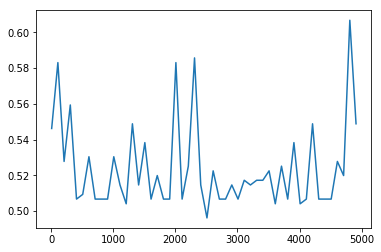

In [16]:
plt.plot(rang, accuracy_list)

# Fit by LSTM Neural Network<a name = "LSTM"></a>

[Back to Top](#backtotop)



In [19]:
max_features = 10000
max_len = 200
tokenizer = Tokenizer(nb_words = max_features)
tokenizer.fit_on_texts(joint_headlines_train)
sequences_train = tokenizer.texts_to_sequences(joint_headlines_train)
sequences_test = tokenizer.texts_to_sequences(joint_headlines_test)
# LSTM_model.fit(basic_train, tf.keras.utils.to_categorical(train_data.Label.values))

In [20]:
X_train = sequence.pad_sequences(sequences_train, maxlen=max_len)
X_test = sequence.pad_sequences(sequences_test, maxlen=max_len)

Y_train = tf.keras.utils.to_categorical(train_data.Label.values)
Y_test = tf.keras.utils.to_categorical(test_data.Label.values)

In [21]:
X_train.shape, Y_train.shape

((1610, 200), (1610, 2))

In [22]:
LSTM_model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim = max_features, output_dim = 200, mask_zero = True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(300,
                             dropout= 0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dense(2, activation = "softmax", input_shape = (32,300))
])


LSTM_model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['categorical_accuracy'])
             
print('Train...')
LSTM_model.fit(X_train, Y_train, batch_size=32, epochs=3)
score, acc = LSTM_model.evaluate(X_test, Y_test,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/3
1610/1610 [==============================] - 37s 23ms/sample - loss: 0.6929 - categorical_accuracy: 0.5298
Epoch 2/3
1610/1610 [==============================] - 36s 22ms/sample - loss: 0.6447 - categorical_accuracy: 0.6832
Epoch 3/3
379/379 [==============================] - 2s 4ms/sample - loss: 0.9341 - categorical_accuracy: 0.5567
Test score: 0.9341191904211422
Test accuracy: 0.55672824


# Fit by Bidirectional LSTM Neural Network<a name = "BD_LSTM"></a>

[Back to Top](#backtotop)

In [36]:
forward_LSTM = tf.keras.layers.LSTM(300, dropout= 0.2, recurrent_dropout=0.2, return_sequences=True)
backward_LSTM = tf.keras.layers.LSTM(300, dropout= 0.2, recurrent_dropout=0.2, return_sequences=True, go_backwards = True)


LSTM_model = tf.keras.models.Sequential()
LSTM_model.add(tf.keras.layers.Embedding(input_dim = max_features, output_dim = 200, mask_zero = True))
LSTM_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True), input_shape=(32, 200)))
LSTM_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)))
LSTM_model.add(tf.keras.layers.Dense(2, activation = "softmax"))


LSTM_model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['categorical_accuracy'])
             
print('Train...')
LSTM_model.fit(X_train, Y_train, batch_size=32, epochs=3)
score, acc = LSTM_model.evaluate(X_test, Y_test,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/3
1610/1610 [==============================] - 172s 107ms/sample - loss: 0.6924 - categorical_accuracy: 0.5379
Epoch 2/3
1610/1610 [==============================] - 172s 107ms/sample - loss: 0.5096 - categorical_accuracy: 0.7944
Epoch 3/3
379/379 [==============================] - 7s 19ms/sample - loss: 1.5092 - categorical_accuracy: 0.5488
Test score: 1.5092410163703254
Test accuracy: 0.5488127


# Fit by Convolutional Neural Network<a name = "CNN"></a>

[Back to Top](#backtotop)

In [53]:
from keras import backend as K

num_filters = 168
CNN_model = tf.keras.models.Sequential()
CNN_model.add(tf.keras.layers.Embedding(input_dim = max_features, output_dim = 200))
CNN_model.add(tf.keras.layers.Convolution1D(filters = num_filters, kernel_size = 20, activation = 'relu'))
def Max1D(X):
    return K.max(X, axis = 1)
CNN_model.add(tf.keras.layers.Lambda(Max1D, output_shape = (num_filters, )))
CNN_model.add(tf.keras.layers.Dense(120, activation = 'relu'))
CNN_model.add(tf.keras.layers.Dropout(0.2))
CNN_model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

CNN_model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['categorical_accuracy'])
CNN_model.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 0.6917 - categorical_accuracy: 0.5298
Epoch 2/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 0.5495 - categorical_accuracy: 0.8522
Epoch 3/10
1610/1610 [==============================] - 7s 5ms/sample - loss: 0.1077 - categorical_accuracy: 1.0000
Epoch 4/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 0.0041 - categorical_accuracy: 1.0000
Epoch 5/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 6/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 7/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 7.8922e-04 - categorical_accuracy: 1.0000
Epoch 8/10
1610/1610 [==============================] - 7s 4ms/sample - loss: 4.8278e-04 - categorical_accuracy: 1.0000
Epoch 9/10
1610/1610 [==============================] - 7s 4ms/s

In [54]:
score, acc = CNN_model.evaluate(X_test, Y_test,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

379/379 [==============================] - 1s 2ms/sample - loss: 0.7241 - categorical_accuracy: 0.5435
Test score: 0.724146212311093
Test accuracy: 0.54353565
